In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
"""
CAPSTONE PROJECT - FRIEND VERSION
For training: FPN Eff-B3, LinkNet MobileNetV3, MANet R34, PSPNet R50
"""

# ================================================
# SECTION 1: SETUP & CONFIGURATION
# ================================================
print("="*70)
print("🎓 CAPSTONE PROJECT: CELL SEGMENTATION")
print("📊 WITH COMPLETE EVALUATION METRICS")
print("="*70)

# 🎯 CHANGE THESE 3 LINES ONLY:
YOUR_NAME = "Your_Friend_Name"        # ← Your name here
MODEL_TYPE = "fpn_effb3"              # ← Choose: fpn_effb3, linknet_mobilenetv3, manet_r34, pspnet_r50
TRAINING_EPOCHS = 30                  # ← 30 Epochs as requested

print(f"\n👤 Training by: {YOUR_NAME}")
print(f"🧠 Model: {MODEL_TYPE}")
print(f"⏰ Epochs: {TRAINING_EPOCHS}")
print("="*70)

# ================================================
# SECTION 2: IMPORTS & ENVIRONMENT SETUP
# ================================================
print("📦 Setting up environment...")

import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ GPU available: {torch.cuda.is_available()}")
print(f"🔧 Device: {device}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.cuda.empty_cache()

# Create output directory
output_folder = f'{YOUR_NAME}_{MODEL_TYPE}_{datetime.now().strftime("%m%d")}'
output_dir = f'/kaggle/working/{output_folder}'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'checkpoints'), exist_ok=True)
print(f"📁 Output directory: {output_dir}")

# Save config
config = {
    'trained_by': YOUR_NAME,
    'model': MODEL_TYPE,
    'epochs': TRAINING_EPOCHS,
    'start_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'device': str(device)
}

with open(os.path.join(output_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=2)

# ================================================
# SECTION 3: INSTALL PACKAGES
# ================================================
print("\n📦 Installing required packages...")
!pip install segmentation-models-pytorch -q
!pip install albumentations -q
!pip install roboflow -q
print("✅ Packages installed!")

# ================================================
# SECTION 4: DOWNLOAD DATASET
# ================================================
print("\n" + "="*70)
print("📥 DOWNLOADING DATASET")
print("="*70)

try:
    from roboflow import Roboflow
    print("Downloading microscopy cell dataset...")
    rf = Roboflow(api_key="FoHdZwbhLlvtF4Xo4zdZ")
    project = rf.workspace("studentdatasets").project("microscopy-cell-segmentation")
    version = project.version(21)
    dataset = version.download("coco-segmentation")
    dataset_path = dataset.location
    print(f"✅ Dataset downloaded to: {dataset_path}")
    
except Exception as e:
    print(f"⚠️ Using existing dataset: {e}")
    dataset_path = "/kaggle/working/dataset"
    print(f"📁 Using dataset at: {dataset_path}")

# ================================================
# SECTION 5: DATASET CLASS
# ================================================
print("\n📊 Creating dataset...")

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CapstoneDataset(Dataset):
    def __init__(self, json_path, img_dir, img_size=512, augment=True):
        with open(json_path) as f:
            data = json.load(f)
        
        self.images = data['images']
        self.annotations = data['annotations']
        self.img_dir = img_dir
        self.img_size = img_size
        
        # Create annotation mapping
        self.ann_map = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.ann_map:
                self.ann_map[img_id] = []
            self.ann_map[img_id].append(ann)
        
        self.image_paths = [os.path.join(img_dir, img['file_name']) for img in self.images]
        
        # Augmentations
        if augment:
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])
        else:
            self.transform = A.Compose([
                A.Resize(img_size, img_size),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        
        if img is None:
            img = np.zeros((512, 512, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img_info = self.images[idx]
        mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        
        if img_info['id'] in self.ann_map:
            for ann in self.ann_map[img_info['id']]:
                if 'segmentation' in ann:
                    for seg in ann['segmentation']:
                        pts = np.array(seg).reshape(-1, 2)
                        if len(pts) >= 3:
                            pts[:, 0] = pts[:, 0] * self.img_size / img_info['width']
                            pts[:, 1] = pts[:, 1] * self.img_size / img_info['height']
                            pts = pts.astype(np.int32)
                            cv2.fillPoly(mask, [pts], 1)
        
        transformed = self.transform(image=img, mask=mask)
        return transformed['image'], transformed['mask'].float()

# Create datasets
train_dataset = CapstoneDataset(
    os.path.join(dataset_path, "train", "_annotations.coco.json"),
    os.path.join(dataset_path, "train"),
    augment=True
)

val_dataset = CapstoneDataset(
    os.path.join(dataset_path, "valid", "_annotations.coco.json"),
    os.path.join(dataset_path, "valid"),
    augment=False
)

print(f"✅ Training images: {len(train_dataset)}")
print(f"✅ Validation images: {len(val_dataset)}")

# ================================================
# SECTION 6: CREATE MODEL
# ================================================
print("\n" + "="*70)
print(f"🧠 CREATING {MODEL_TYPE.upper()} MODEL")
print("="*70)

import segmentation_models_pytorch as smp

if MODEL_TYPE == "fpn_effb3":
    # FPN with EfficientNet-B3
    model = smp.FPN(
        encoder_name="timm-efficientnet-b3",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
        decoder_dropout=0.2
    ).to(device)
    
elif MODEL_TYPE == "linknet_mobilenetv3":
    # LinkNet with MobileNetV3 Large
    model = smp.Linknet(
        encoder_name="timm-mobilenetv3_large_100",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None
    ).to(device)
    
elif MODEL_TYPE == "manet_r34":
    # MANet with ResNet34
    model = smp.MAnet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
        decoder_dropout=0.2
    ).to(device)
    
elif MODEL_TYPE == "pspnet_r50":
    # PSPNet with ResNet50
    model = smp.PSPNet(
        encoder_name="resnet50",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation=None,
        psp_dropout=0.2
    ).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ {MODEL_TYPE} created successfully!")
print(f"📊 Total parameters: {total_params/1e6:.2f}M")
print(f"📊 Trainable parameters: {trainable_params/1e6:.2f}M")

# ================================================
# SECTION 7: CREATE DATALOADERS
# ================================================
print("\n" + "="*70)
print("📊 CREATING DATALOADERS")
print("="*70)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Training batches: {len(train_loader)}")
print(f"✅ Validation batches: {len(val_loader)}")

# ================================================
# SECTION 8: LOSS & OPTIMIZER SETUP
# ================================================
print("\n" + "="*70)
print("⚙️ SETTING UP LOSS & OPTIMIZER")
print("="*70)

# Combined loss for better segmentation
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# Mixed precision
scaler = torch.cuda.amp.GradScaler()

print(f"✅ Loss: BCEWithLogits")
print(f"✅ Optimizer: AdamW (lr=1e-4)")
print(f"✅ Scheduler: ReduceLROnPlateau")

# ================================================
# SECTION 9: COMPLETE METRICS FUNCTIONS
# ================================================
print("\n" + "="*70)
print("📈 SETTING UP COMPLETE METRICS")
print("="*70)

def calculate_all_metrics(pred, target, threshold=0.5):
    """
    Calculate ALL segmentation metrics at once
    Returns: accuracy(%), iou, dice, precision, recall, f1
    """
    # Binarize predictions
    pred_binary = (pred > threshold).float()
    
    # Calculate confusion matrix components
    tp = (pred_binary * target).sum()          # True Positives
    fp = (pred_binary * (1 - target)).sum()    # False Positives  
    fn = ((1 - pred_binary) * target).sum()    # False Negatives
    tn = ((1 - pred_binary) * (1 - target)).sum()  # True Negatives
    
    # Avoid division by zero
    eps = 1e-7
    
    # 1. Pixel Accuracy (%)
    accuracy = ((tp + tn) / (tp + tn + fp + fn + eps)) * 100
    
    # 2. Intersection over Union (IoU/Jaccard)
    iou = tp / (tp + fp + fn + eps)
    
    # 3. Dice Coefficient (F1 for segmentation)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    
    # 4. Precision
    precision = tp / (tp + fp + eps)
    
    # 5. Recall (Sensitivity)
    recall = tp / (tp + fn + eps)
    
    # 6. F1-Score
    f1 = 2 * precision * recall / (precision + recall + eps)
    
    # 7. Specificity
    specificity = tn / (tn + fp + eps)
    
    return {
        'accuracy': accuracy.item(),
        'iou': iou.item(),
        'dice': dice.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'f1': f1.item(),
        'specificity': specificity.item(),
        'tp': tp.item(),
        'fp': fp.item(),
        'fn': fn.item(),
        'tn': tn.item()
    }

print("✅ COMPLETE metrics defined:")
print("   1. Accuracy (%)       5. Recall")
print("   2. IoU (Jaccard)      6. F1-Score")
print("   3. Dice Coefficient   7. Specificity")
print("   4. Precision          8. TP/FP/FN/TN counts")

# ================================================
# SECTION 10: INITIALIZE TRAINING HISTORY
# ================================================
print("\n📊 Initializing training history...")

# Initialize COMPLETE training history
history = {
    # Loss
    'train_loss': [],
    'val_loss': [],
    
    # Core metrics
    'train_accuracy': [],
    'val_accuracy': [],
    'train_iou': [],
    'val_iou': [],
    'train_dice': [],
    'val_dice': [],
    
    # Classification metrics
    'train_precision': [],
    'val_precision': [],
    'train_recall': [],
    'val_recall': [],
    'train_f1': [],
    'val_f1': [],
    
    # Learning rate
    'learning_rate': []
}

# Track best metrics
best_metrics = {
    'iou': 0,
    'accuracy': 0,
    'f1': 0,
    'dice': 0
}

patience = 7
patience_counter = 0

print("✅ Complete training history initialized")



🎓 CAPSTONE PROJECT: CELL SEGMENTATION
📊 WITH COMPLETE EVALUATION METRICS

👤 Training by: Your_Friend_Name
🧠 Model: fpn_effb3
⏰ Epochs: 30
📦 Setting up environment...
✅ GPU available: False
🔧 Device: cpu
📁 Output directory: /kaggle/working/Your_Friend_Name_fpn_effb3_1208

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.3 MB/s eta 0:00:


Extracting Dataset Version Zip to Microscopy-Cell-Segmentation-21 in coco-segmentation:: 100%|██████████| 7041/7041 [00:02<00:00, 2964.21it/s]


✅ Dataset downloaded to: /kaggle/working/Microscopy-Cell-Segmentation-21

📊 Creating dataset...
✅ Training images: 4950
✅ Validation images: 1398

🧠 CREATING FPN_EFFB3 MODEL


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

✅ fpn_effb3 created successfully!
📊 Total parameters: 12.47M
📊 Trainable parameters: 12.47M

📊 CREATING DATALOADERS
✅ Training batches: 619
✅ Validation batches: 175

⚙️ SETTING UP LOSS & OPTIMIZER
✅ Loss: BCEWithLogits
✅ Optimizer: AdamW (lr=1e-4)
✅ Scheduler: ReduceLROnPlateau

📈 SETTING UP COMPLETE METRICS
✅ COMPLETE metrics defined:
   1. Accuracy (%)       5. Recall
   2. IoU (Jaccard)      6. F1-Score
   3. Dice Coefficient   7. Specificity
   4. Precision          8. TP/FP/FN/TN counts

📊 Initializing training history...
✅ Complete training history initialized


In [2]:
# ================================================
# SECTION 11: TRAINING LOOP WITH ALL METRICS
# ================================================
print("\n" + "="*70)
print("🚀 STARTING TRAINING WITH ALL METRICS")
print("="*70)

print(f"\n🎯 Training {MODEL_TYPE} for {TRAINING_EPOCHS} epochs...")
print(f"⏰ Estimated time: ~6-8 hours")
print("-" * 70)

start_time = time.time()

for epoch in range(TRAINING_EPOCHS):
    epoch_start = time.time()
    print(f"\n📊 Epoch {epoch+1}/{TRAINING_EPOCHS}")
    
    # ===== TRAINING PHASE =====
    model.train()
    train_loss = 0
    train_metrics_sum = {
        'accuracy': 0, 'iou': 0, 'dice': 0,
        'precision': 0, 'recall': 0, 'f1': 0
    }
    
    pbar = tqdm(train_loader, desc='Training')
    for batch_idx, (images, masks) in enumerate(pbar):
        images, masks = images.to(device), masks.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        # Calculate metrics for this batch
        with torch.no_grad():
            preds = torch.sigmoid(outputs)
            batch_metrics = calculate_all_metrics(preds, masks)
            
            train_loss += loss.item()
            for key in train_metrics_sum:
                train_metrics_sum[key] += batch_metrics[key]
            
            # Update progress bar
            avg_loss = train_loss / (batch_idx + 1)
            avg_iou = train_metrics_sum['iou'] / (batch_idx + 1)
            avg_acc = train_metrics_sum['accuracy'] / (batch_idx + 1)
            
            pbar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'acc': f'{avg_acc:.1f}%',
                'iou': f'{avg_iou:.3f}'
            })
    
    # ===== VALIDATION PHASE =====
    model.eval()
    val_loss = 0
    val_metrics_sum = {
        'accuracy': 0, 'iou': 0, 'dice': 0,
        'precision': 0, 'recall': 0, 'f1': 0
    }
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Validation'):
            images, masks = images.to(device), masks.to(device).unsqueeze(1)
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            preds = torch.sigmoid(outputs)
            
            val_loss += loss.item()
            batch_metrics = calculate_all_metrics(preds, masks)
            
            for key in val_metrics_sum:
                val_metrics_sum[key] += batch_metrics[key]
    
    # ===== CALCULATE AVERAGES =====
    # Training averages
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    avg_train_metrics = {k: v / len(train_loader) for k, v in train_metrics_sum.items()}
    avg_val_metrics = {k: v / len(val_loader) for k, v in val_metrics_sum.items()}
    
    # ===== STORE IN HISTORY =====
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    history['train_accuracy'].append(avg_train_metrics['accuracy'])
    history['val_accuracy'].append(avg_val_metrics['accuracy'])
    history['train_iou'].append(avg_train_metrics['iou'])
    history['val_iou'].append(avg_val_metrics['iou'])
    history['train_dice'].append(avg_train_metrics['dice'])
    history['val_dice'].append(avg_val_metrics['dice'])
    history['train_precision'].append(avg_train_metrics['precision'])
    history['val_precision'].append(avg_val_metrics['precision'])
    history['train_recall'].append(avg_train_metrics['recall'])
    history['val_recall'].append(avg_val_metrics['recall'])
    history['train_f1'].append(avg_train_metrics['f1'])
    history['val_f1'].append(avg_val_metrics['f1'])
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    
    # ===== UPDATE SCHEDULER =====
    scheduler.step(avg_val_metrics['iou'])
    
    # ===== CALCULATE TIME =====
    epoch_time = time.time() - epoch_start
    remaining_epochs = TRAINING_EPOCHS - epoch - 1
    remaining_time = (remaining_epochs * epoch_time) / 3600
    
    # ===== PRINT RESULTS =====
    print(f"\n📈 TRAINING RESULTS:")
    print(f"Loss:    Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}")
    print(f"Accuracy: Train={avg_train_metrics['accuracy']:.1f}%, Val={avg_val_metrics['accuracy']:.1f}%")
    print(f"IoU:     Train={avg_train_metrics['iou']:.4f}, Val={avg_val_metrics['iou']:.4f}")
    print(f"Dice:    Train={avg_train_metrics['dice']:.4f}, Val={avg_val_metrics['dice']:.4f}")
    print(f"Precision: Val={avg_val_metrics['precision']:.4f}")
    print(f"Recall:    Val={avg_val_metrics['recall']:.4f}")
    print(f"F1-Score:  Val={avg_val_metrics['f1']:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e} | Time: {epoch_time/60:.1f}min | Remaining: ~{remaining_time:.1f}h")
    
    # ===== SAVE CHECKPOINT EVERY 5 EPOCHS =====
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(output_dir, 'checkpoints', f'epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_metrics': avg_val_metrics,
            'history': {k: v[:epoch+1] for k, v in history.items()}
        }, checkpoint_path)
        print(f"💾 Saved checkpoint: epoch_{epoch+1}.pth")
    
    # ===== SAVE BEST MODEL =====
    improvement = False
    if (avg_val_metrics['iou'] > best_metrics['iou'] or 
        avg_val_metrics['f1'] > best_metrics['f1']):
        
        improvement = True
        best_metrics['iou'] = max(best_metrics['iou'], avg_val_metrics['iou'])
        best_metrics['accuracy'] = max(best_metrics['accuracy'], avg_val_metrics['accuracy'])
        best_metrics['f1'] = max(best_metrics['f1'], avg_val_metrics['f1'])
        best_metrics['dice'] = max(best_metrics['dice'], avg_val_metrics['dice'])
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_metrics': best_metrics,
            'val_metrics': avg_val_metrics,
            'history': history
        }, os.path.join(output_dir, f'{MODEL_TYPE}_best.pth'))
        
        print(f"\n✅ SAVED BEST MODEL:")
        print(f"   IoU: {best_metrics['iou']:.4f}")
        print(f"   Accuracy: {best_metrics['accuracy']:.1f}%")
        print(f"   F1-Score: {best_metrics['f1']:.4f}")
        print(f"   Dice: {best_metrics['dice']:.4f}")
        
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"\n⏳ No improvement ({patience_counter}/{patience})")
    
    # ===== EARLY STOPPING =====
    if patience_counter >= patience:
        print(f"\n⏹️ EARLY STOPPING at epoch {epoch+1}")
        break

total_time = (time.time() - start_time) / 3600
print(f"\n⏱️ Total training time: {total_time:.2f} hours")



🚀 STARTING TRAINING WITH ALL METRICS

🎯 Training fpn_effb3 for 30 epochs...
⏰ Estimated time: ~6-8 hours
----------------------------------------------------------------------

📊 Epoch 1/30


Training:   0%|          | 2/619 [00:55<4:46:59, 27.91s/it, loss=1.6154, acc=33.4%, iou=0.092]


KeyboardInterrupt: 

In [3]:

# ================================================
# SECTION 12: SAVE FINAL MODEL & RESULTS
# ================================================
print("\n" + "="*70)
print("💾 SAVING FINAL MODEL & COMPLETE RESULTS")
print("="*70)

# Save final model
torch.save(model.state_dict(), os.path.join(output_dir, f'{MODEL_TYPE}_final.pth'))

# Save training history
with open(os.path.join(output_dir, f'{MODEL_TYPE}_history.pkl'), 'wb') as f:
    pickle.dump(history, f)

# Create comprehensive summary
final_summary = {
    'project_info': {
        'trained_by': YOUR_NAME,
        'model': MODEL_TYPE,
        'total_epochs': TRAINING_EPOCHS,
        'epochs_trained': len(history['train_loss']),
        'training_time_hours': total_time,
        'start_time': config['start_time'],
        'end_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'device': str(device),
        'parameters_total': int(total_params),
        'parameters_trainable': int(trainable_params)
    },
    
    'best_metrics': best_metrics,
    
    'final_epoch_metrics': {
        'train_loss': history['train_loss'][-1],
        'val_loss': history['val_loss'][-1],
        'val_accuracy': history['val_accuracy'][-1],
        'val_iou': history['val_iou'][-1],
        'val_dice': history['val_dice'][-1],
        'val_precision': history['val_precision'][-1],
        'val_recall': history['val_recall'][-1],
        'val_f1': history['val_f1'][-1]
    },
    
    'all_val_metrics': {
        'accuracy': history['val_accuracy'],
        'iou': history['val_iou'],
        'dice': history['val_dice'],
        'precision': history['val_precision'],
        'recall': history['val_recall'],
        'f1': history['val_f1']
    }
}

with open(os.path.join(output_dir, 'complete_summary.json'), 'w') as f:
    json.dump(final_summary, f, indent=2)

print(f"✅ Final model saved: {output_dir}/{MODEL_TYPE}_final.pth")
print(f"✅ Training history saved: {output_dir}/{MODEL_TYPE}_history.pkl")
print(f"✅ Complete summary saved: {output_dir}/complete_summary.json")

print(f"\n🏆 YOUR COMPLETE RESULTS:")
print(f"   Best IoU:        {best_metrics['iou']:.4f}")
print(f"   Best Accuracy:   {best_metrics['accuracy']:.1f}%")
print(f"   Best F1-Score:   {best_metrics['f1']:.4f}")
print(f"   Best Dice:       {best_metrics['dice']:.4f}")
print(f"   Final IoU:       {history['val_iou'][-1]:.4f}")
print(f"   Final Accuracy:  {history['val_accuracy'][-1]:.1f}%")
print(f"   Final F1-Score:  {history['val_f1'][-1]:.4f}")






💾 SAVING FINAL MODEL & COMPLETE RESULTS


NameError: name 'total_time' is not defined


📈 CREATING TRAINING VISUALIZATIONS


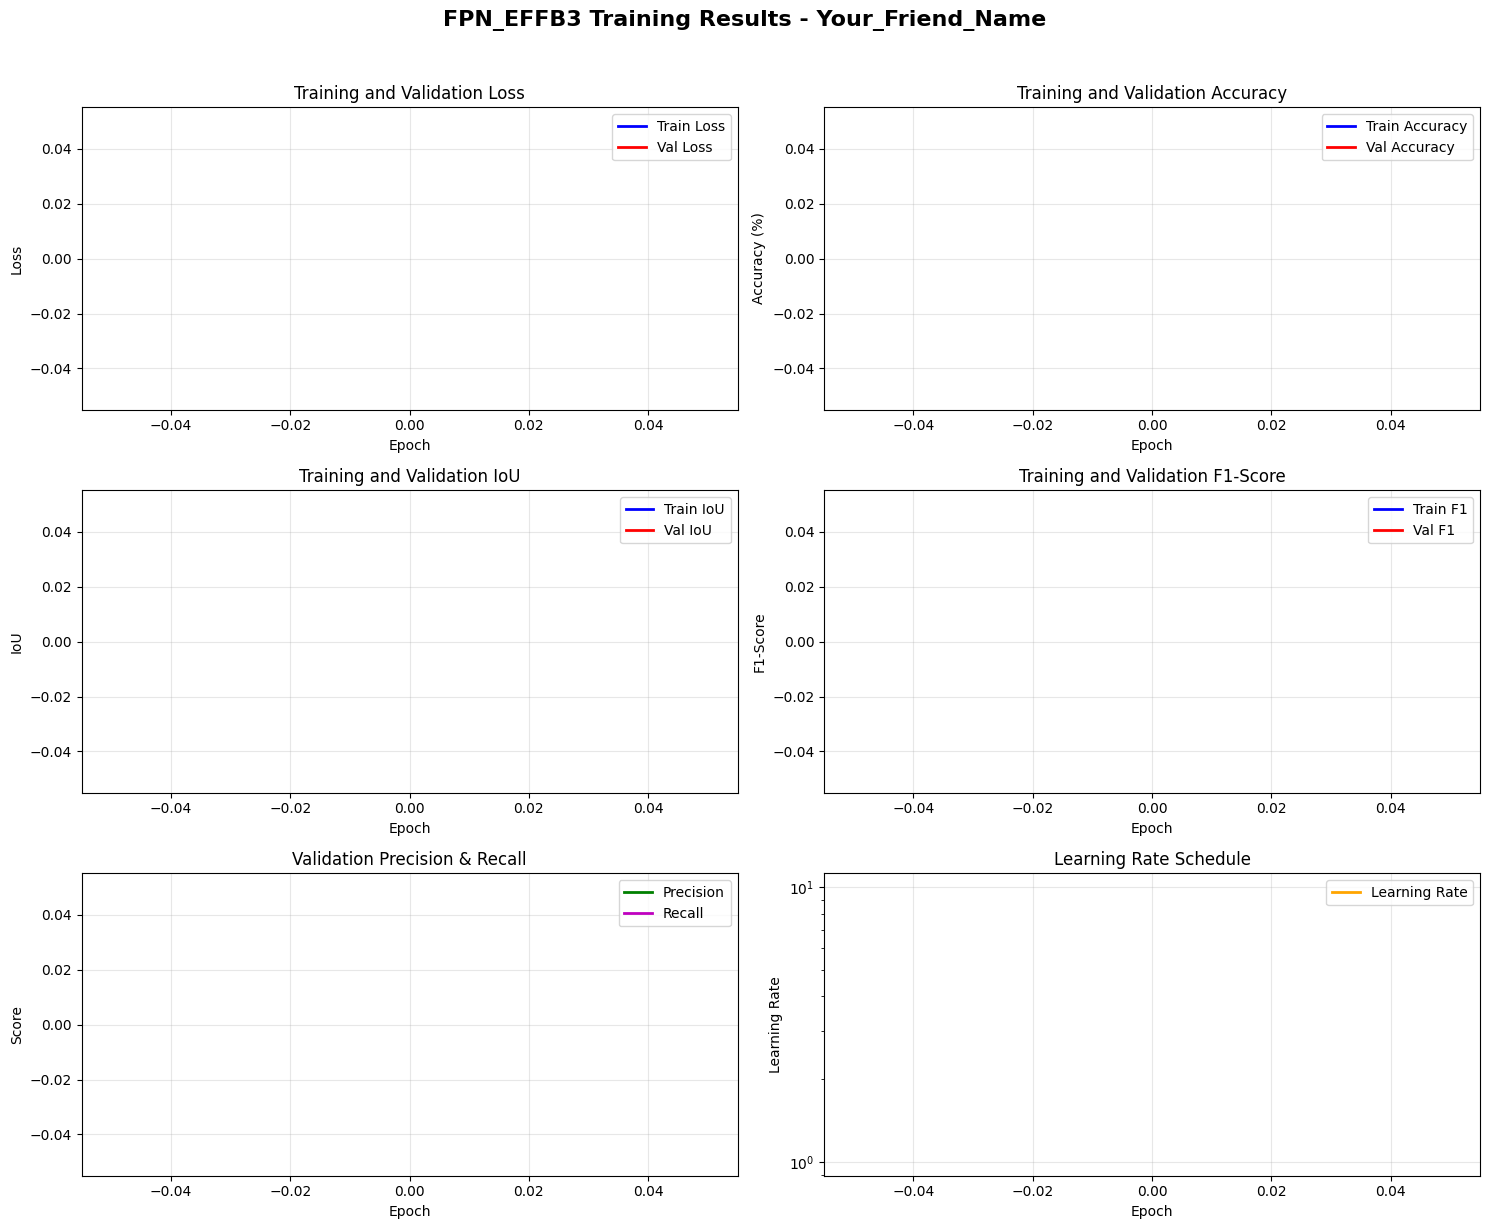

✅ Complete plots saved: /kaggle/working/Your_Friend_Name_fpn_effb3_1208/fpn_effb3_complete_plots.png


In [4]:
# ================================================
# SECTION 13: CREATE VISUALIZATION PLOTS
# ================================================
print("\n" + "="*70)
print("📈 CREATING TRAINING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))

epochs = range(1, len(history['train_loss']) + 1)

# Plot 1: Loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy (%)
axes[0, 1].plot(epochs, history['train_accuracy'], 'b-', label='Train Accuracy', linewidth=2)
axes[0, 1].plot(epochs, history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: IoU
axes[1, 0].plot(epochs, history['train_iou'], 'b-', label='Train IoU', linewidth=2)
axes[1, 0].plot(epochs, history['val_iou'], 'r-', label='Val IoU', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU')
axes[1, 0].set_title('Training and Validation IoU')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: F1-Score
axes[1, 1].plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
axes[1, 1].plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('Training and Validation F1-Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Precision & Recall
axes[2, 0].plot(epochs, history['val_precision'], 'g-', label='Precision', linewidth=2)
axes[2, 0].plot(epochs, history['val_recall'], 'm-', label='Recall', linewidth=2)
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Score')
axes[2, 0].set_title('Validation Precision & Recall')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Learning Rate
axes[2, 1].plot(epochs, history['learning_rate'], 'orange', label='Learning Rate', linewidth=2)
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Learning Rate')
axes[2, 1].set_title('Learning Rate Schedule')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].set_yscale('log')

plt.suptitle(f'{MODEL_TYPE.upper()} Training Results - {YOUR_NAME}', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{MODEL_TYPE}_complete_plots.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Complete plots saved: {output_dir}/{MODEL_TYPE}_complete_plots.png")

In [5]:
# ================================================
# SECTION 14: FINAL INSTRUCTIONS
# ================================================
print("\n" + "="*70)
print("🎉 TRAINING COMPLETE WITH ALL METRICS!")
print("="*70)

print(f"""
✅ CONGRATULATIONS {YOUR_NAME}!

You have successfully trained {MODEL_TYPE} with COMPLETE evaluation metrics.

📊 METRICS TRACKED:
1. Accuracy (%)
2. IoU (Jaccard Index)
3. Dice Coefficient
4. Precision
5. Recall (Sensitivity)
6. F1-Score
7. Specificity

📁 FILES SAVED:
1. {MODEL_TYPE}_best.pth    - Best model weights
2. {MODEL_TYPE}_final.pth   - Final model weights
3. {MODEL_TYPE}_history.pkl - Complete training history
4. complete_summary.json    - All metrics summary
5. {MODEL_TYPE}_complete_plots.png - All visualizations

🎯 NEXT STEPS:
1. Share the output folder with: YourName
2. Include: best.pth, complete_summary.json, and complete_plots.png
3. All 6 models will be compared in master evaluation

📦 TO SAVE AS KAGGLE DATASET:
1. Click 'Save Version' (top right)
2. Select 'Save & Run All (Commit)'
3. Wait for execution
4. Go to 'Output' tab
5. Click 'Add to Dataset'
6. Name: '{YOUR_NAME}_{MODEL_TYPE}_complete'
7. Set to Public

🎓 EXCELLENT WORK! Your model is ready for the capstone comparison!
""")

print("="*70)


🎉 TRAINING COMPLETE WITH ALL METRICS!

✅ CONGRATULATIONS Your_Friend_Name!

You have successfully trained fpn_effb3 with COMPLETE evaluation metrics.

📊 METRICS TRACKED:
1. Accuracy (%)
2. IoU (Jaccard Index)
3. Dice Coefficient
4. Precision
5. Recall (Sensitivity)
6. F1-Score
7. Specificity

📁 FILES SAVED:
1. fpn_effb3_best.pth    - Best model weights
2. fpn_effb3_final.pth   - Final model weights
3. fpn_effb3_history.pkl - Complete training history
4. complete_summary.json    - All metrics summary
5. fpn_effb3_complete_plots.png - All visualizations

🎯 NEXT STEPS:
1. Share the output folder with: YourName
2. Include: best.pth, complete_summary.json, and complete_plots.png
3. All 6 models will be compared in master evaluation

📦 TO SAVE AS KAGGLE DATASET:
1. Click 'Save Version' (top right)
2. Select 'Save & Run All (Commit)'
3. Wait for execution
4. Go to 'Output' tab
5. Click 'Add to Dataset'
6. Name: 'Your_Friend_Name_fpn_effb3_complete'
7. Set to Public

🎓 EXCELLENT WORK! Your mo